In [12]:
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
import keras

# Data processing 

Cut the silences and focus on the digit part of the sound

In [13]:
for i in range(6):
    
    address = './'+str(i)+'/'
    
    files = sorted(os.listdir(address), reverse=False)
    
    for file in files:
        if file[0:3]=="cut":
            os.remove(address+file)
        else:
            if file[len(file)-3:]!=".py":
    
                fs, data = wavfile.read(address+file)
                
                data_norm = data/np.percentile(data,99)
                n = len(data_norm)
                
                margin = 5000
                silence_threshold = 0.7
                step = 50
                
                first_word = False
                first_word_index = 0
                last_word = False
                last_word_index = 60000
                
                for i in np.arange(step,n-step,step):
                    
                    if not first_word:
                        if np.mean(np.abs(data_norm[i-step:i+step])) > silence_threshold:
                            first_word = True
                            first_word_index = i
                
                    if not last_word:
                        if np.mean(np.abs(data_norm[n-i-step:n-i+step])) > silence_threshold:
                            last_word = True
                            last_word_index = n-i
                
                first_word_index = max(0,first_word_index-margin)
                last_word_index = min(n,last_word_index+margin)
                
                real_data = data[first_word_index:last_word_index]
                
                normalized_data = (np.iinfo(np.int32).max * real_data).astype(np.int32)
                
                wavfile.write(address+'cut_'+file, fs, normalized_data)

Plot the curves to detect some patterns with visualization

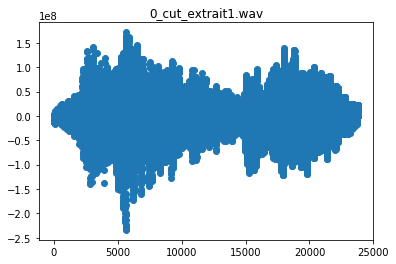

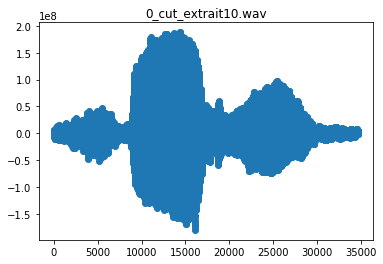

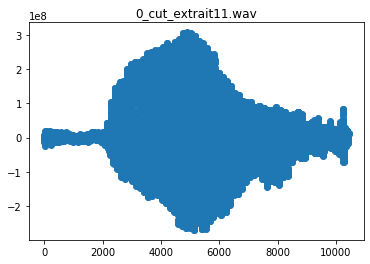

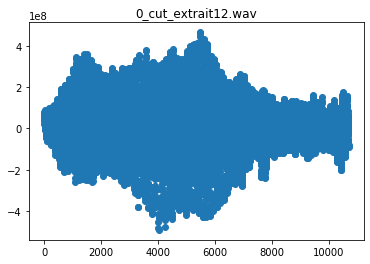

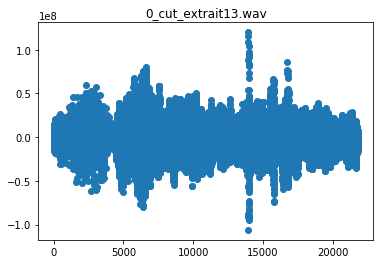

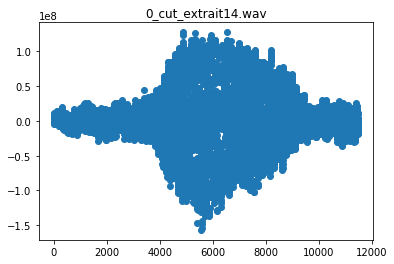

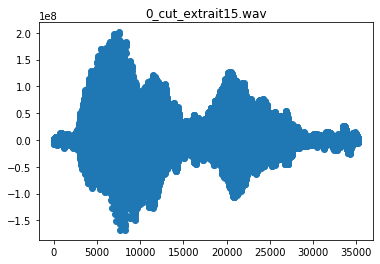

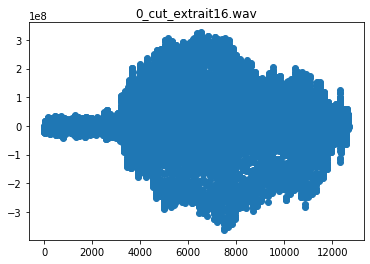

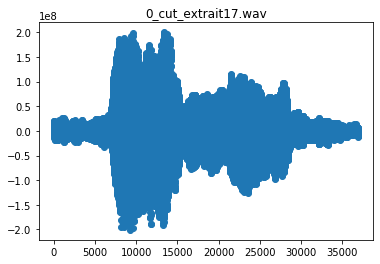

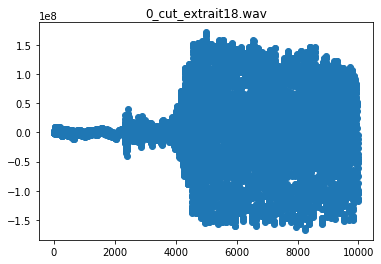

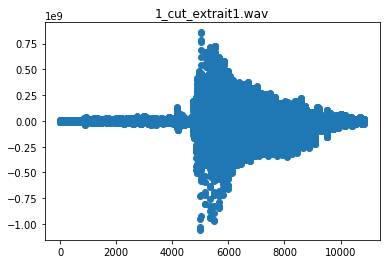

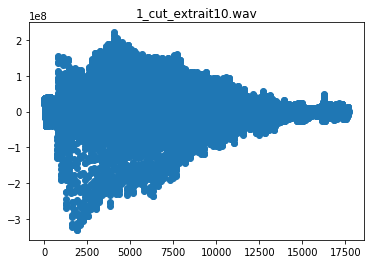

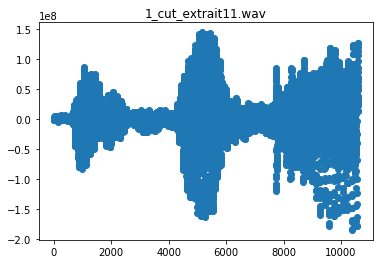

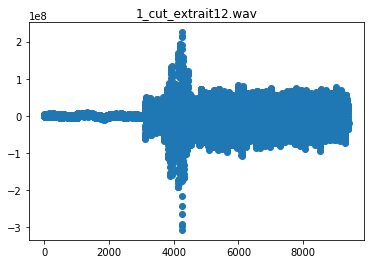

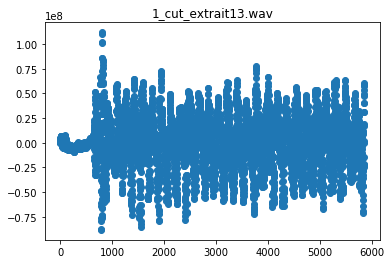

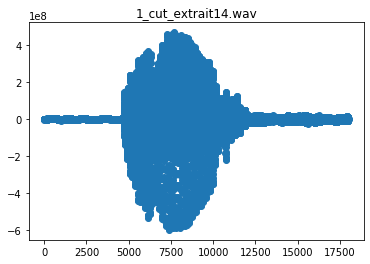

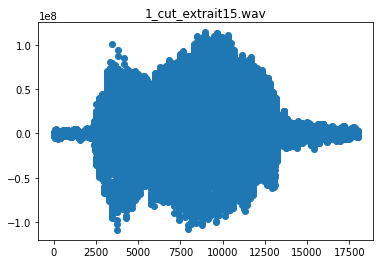

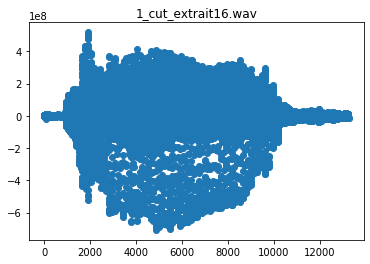

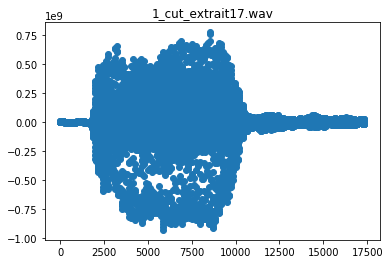

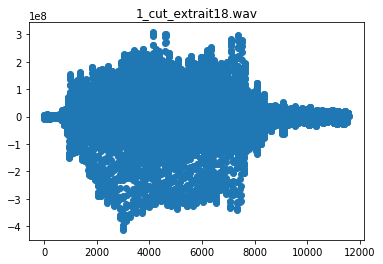

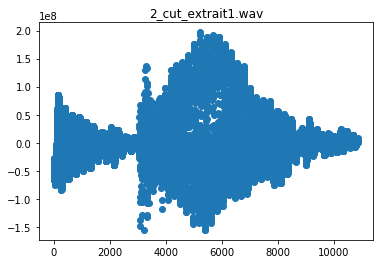

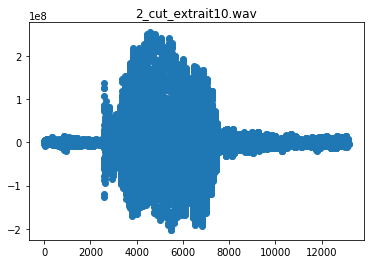

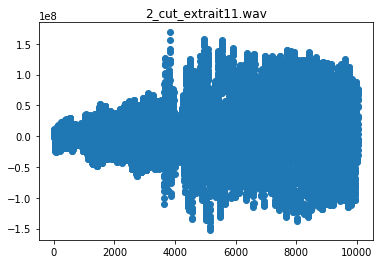

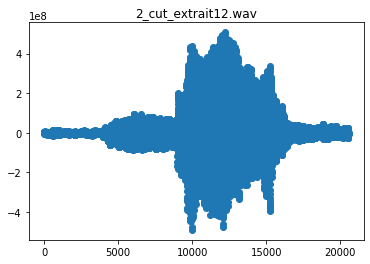

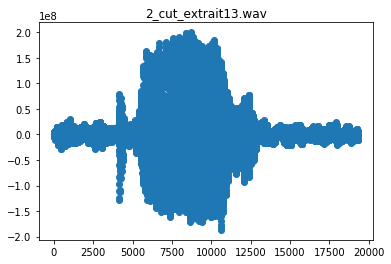

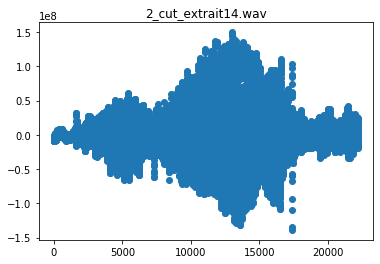

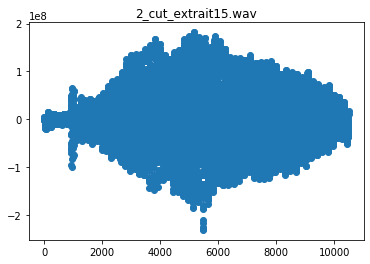

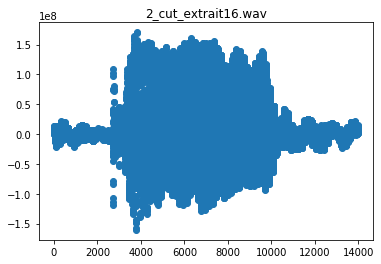

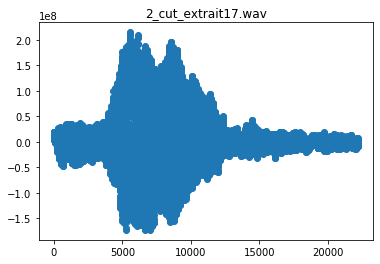

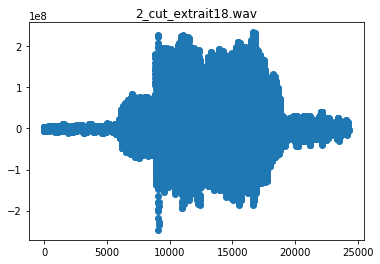

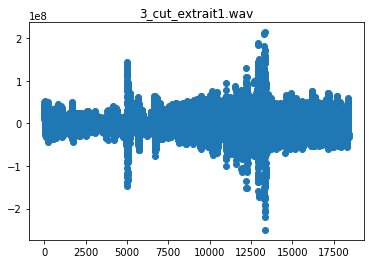

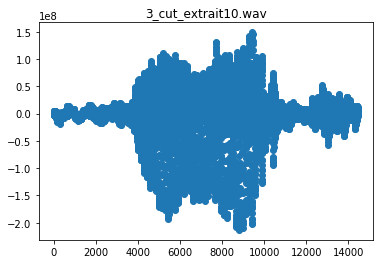

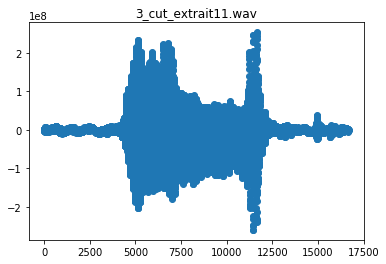

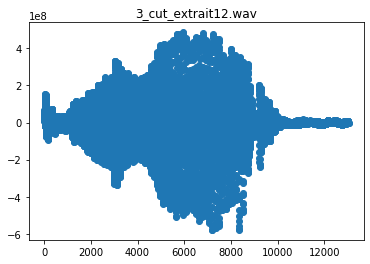

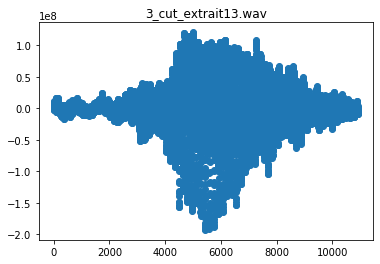

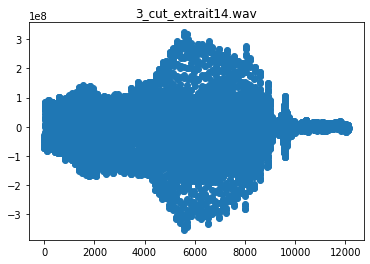

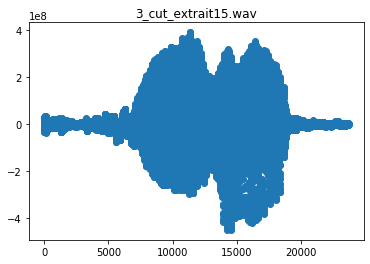

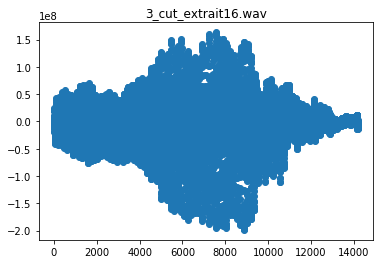

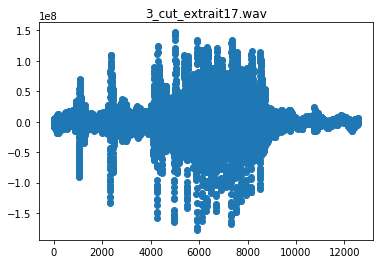

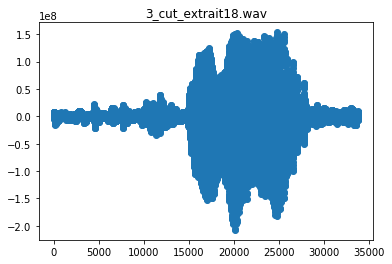

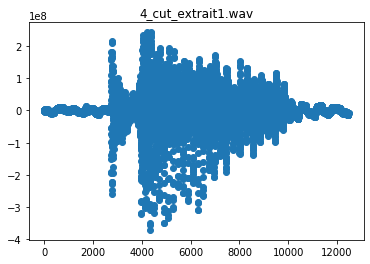

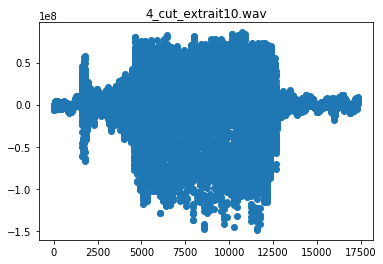

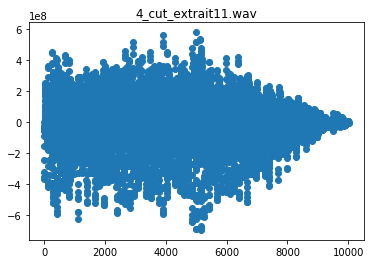

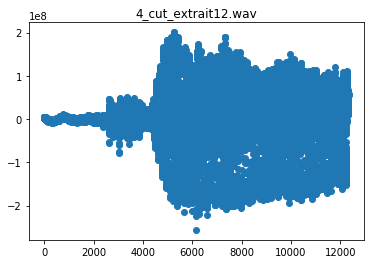

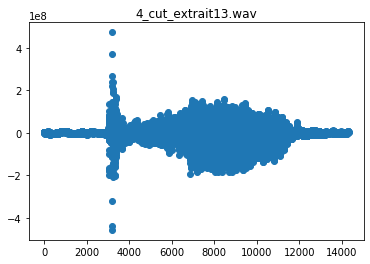

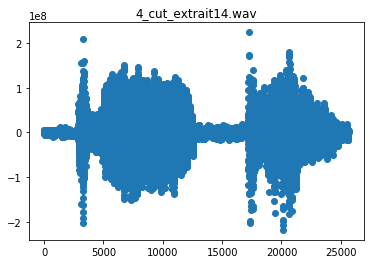

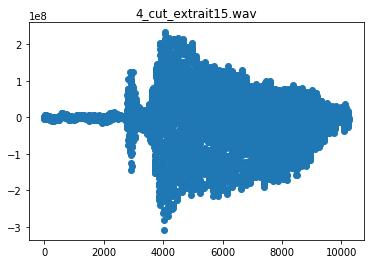

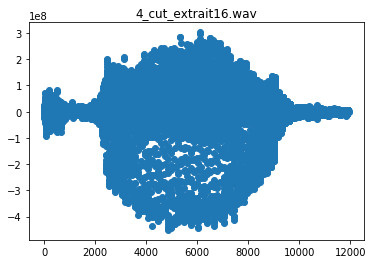

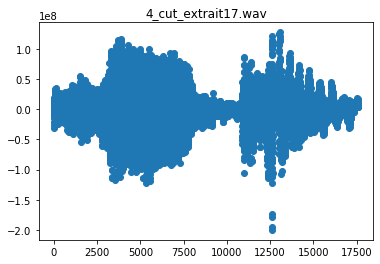

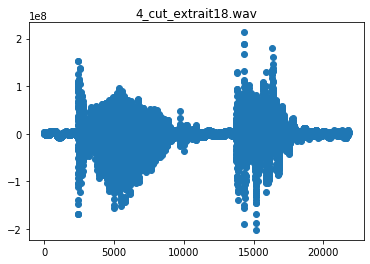

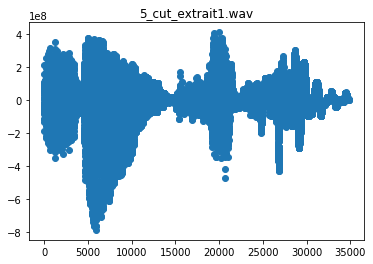

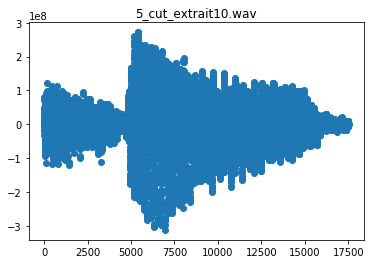

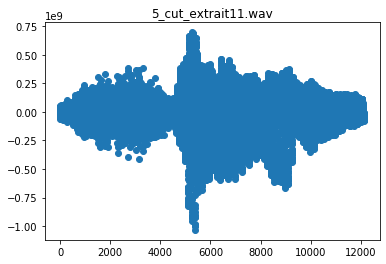

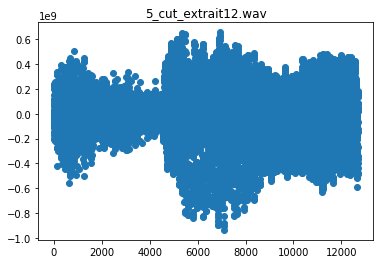

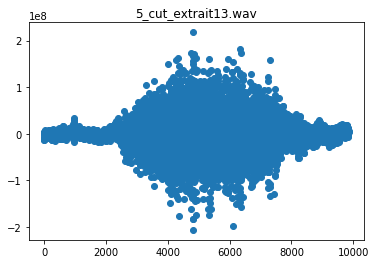

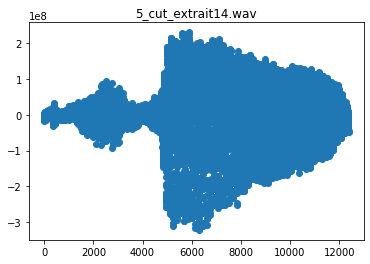

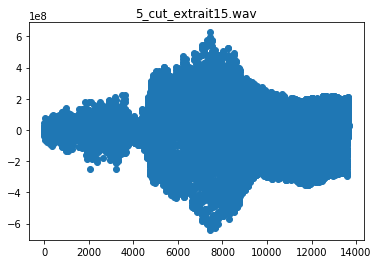

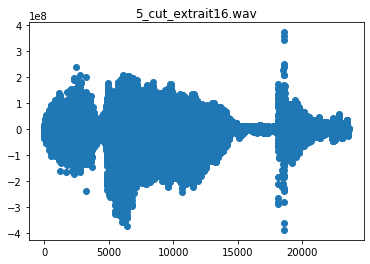

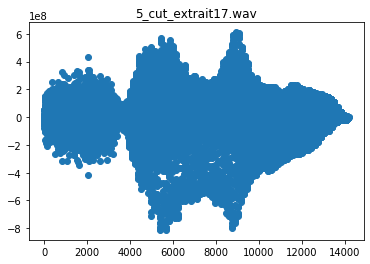

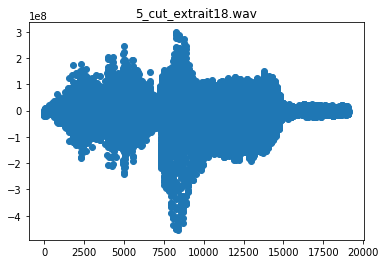

In [14]:
for i in range(6):
    
    address = './'+str(i)+'/'
    
    files = sorted(os.listdir(address), reverse=False)
    
    for file in files[0:10]:
        
        if file[0:3]=="cut":
            fs, data = wavfile.read(address+file)
            
            if i == 5:
                plt.title(str(i)+'_'+file)
                plt.scatter(np.arange(0,len(data),1), data)
                plt.show()
            else:
                plt.title(str(i)+'_'+file)
                plt.scatter(np.arange(0,len(data),1), np.mean(data, axis=1))
                plt.show()

Hard to detect patterns in these graphs

In [15]:
x = []
y = []
sampling_length = 5000

for i in range(6):
    
    address = './'+str(i)+'/'
    
    files = sorted(os.listdir(address), reverse=False)
    
    for file in files:
        
        if file[0:3]=="cut":
            
            fs, data = wavfile.read(address+file)
            
            max_value = np.max(np.abs(data))
            sampling = []
            
            if i == 5:
                for j in range(sampling_length):
                    sampling.append(data[int(len(data)*j/5000)]/max_value)
            else:
                data_mono = np.mean(data, axis=1)
                for j in range(sampling_length):
                    sampling.append(data_mono[int(len(data)*j/5000)]/max_value)
            
            x.append(sampling)
            y.append(i)

Splits the audio files and labels into training and testing 

In [16]:
audio = np.array(x, dtype=np.float32)
labels = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(audio, labels, train_size = 0.9)

num_classes = 6
num_epochs = 5
batch_size = 5

x_train = np.array(x_train, dtype =float)
x_test = np.array(x_test, dtype =float)


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Model

Input:
- A sound file, sampled (5000 observations each) and normalized

Output:
- A digits between 0 and 5

In [19]:
model = Sequential()
model.add(Dense(1000, activation ='relu', input_dim = sampling_length))
model.add(Dropout(0.2))
model.add(Dense(100))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x_train, y_train, 
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test))

Train on 226 samples, validate on 26 samples
Epoch 1/5
226/226 [==============================] - 9s 41ms/step - loss: 3.3882 - accuracy: 0.1593 - val_loss: 3.9332 - val_accuracy: 0.1538
Epoch 2/5
226/226 [==============================] - 9s 40ms/step - loss: 0.4927 - accuracy: 0.8938 - val_loss: 5.0079 - val_accuracy: 0.1923
Epoch 3/5
226/226 [==============================] - 9s 39ms/step - loss: 0.2443 - accuracy: 0.9735 - val_loss: 5.2750 - val_accuracy: 0.2308
Epoch 4/5
226/226 [==============================] - 9s 39ms/step - loss: 0.0238 - accuracy: 0.9956 - val_loss: 5.1897 - val_accuracy: 0.2308
Epoch 5/5
226/226 [==============================] - 9s 40ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.2228 - val_accuracy: 0.1923


Discussion about the results;
- With the actual dataset of spoken digits, it's quite impossible to generalize the results to other songs
- In fact, it's just learning over the 226 songs we give in inputs, and does not recognize efficiently the test digits. The prediction of the digit is equivalent to a uniform prediction (in term of accuracy)
- The dataset should be larger